In [2]:
pip install tensorflow matplotlib scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, json, time, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [3]:
# paths
PROCESSED_DIR = "../data/processed"
MODEL_DIR     = "models"
RESULTS_DIR   = "results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# classes (match your preprocessing mapping)
CLASS_NAMES = ["Closed_Eyes","Open_Eyes","Yawn","No_Yawn"]
num_classes = len(CLASS_NAMES)

# reproducibility (good for fair comparisons)
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
X_train = np.load(f"{PROCESSED_DIR}/X_train.npy")
y_train = np.load(f"{PROCESSED_DIR}/y_train.npy")
X_val   = np.load(f"{PROCESSED_DIR}/X_val.npy")
y_val   = np.load(f"{PROCESSED_DIR}/y_val.npy")
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")

input_shape = X_train.shape[1:]  # (64,64,3) if you followed earlier guide
print("shapes:", X_train.shape, X_val.shape, X_test.shape, " | input:", input_shape)

shapes: (1726, 64, 64, 3) (496, 64, 64, 3) (245, 64, 64, 3)  | input: (64, 64, 3)


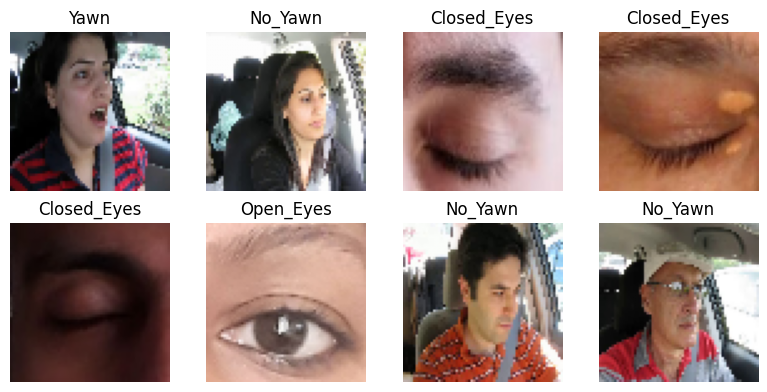

In [5]:
plt.figure(figsize=(8,4))
for i in range(8):
    idx = np.random.randint(0, len(X_train))
    plt.subplot(2,4,i+1); plt.imshow(X_train[idx]); plt.title(CLASS_NAMES[y_train[idx]]); plt.axis('off')
plt.tight_layout(); plt.show()

handle class imbalance

In [6]:
classes = np.arange(num_classes)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights_dict = {i:w for i,w in enumerate(class_weights)}
class_weights_dict

{0: np.float64(0.9988425925925926),
 1: np.float64(0.9988425925925926),
 2: np.float64(1.0011600928074247),
 3: np.float64(1.0011600928074247)}

In [7]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
], name="data_augmentation")

In [8]:
def build_baseline_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = data_aug(inputs)  # augmentation in-graph (only during training)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.35)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.35)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="baseline_cnn")
    return model

model = build_baseline_cnn(input_shape, num_classes)
model.summary()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,364 (4.36 MB)

 Trainable params: 1,142,916 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

run_id = time.strftime("%Y%m%d-%H%M%S")
ckpt_path = f"{MODEL_DIR}/baseline_cnn_best_{run_id}.keras"
log_dir   = f"{RESULTS_DIR}/logs_{run_id}"

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=log_dir)
]

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights_dict,   # remove this arg if you choose not to use class weights
    verbose=1
)

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5775 - loss: 2.0432
Epoch 1: val_accuracy improved from None to 0.25000, saving model to models/baseline_cnn_best_20251009-191546.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 488ms/step - accuracy: 0.6645 - loss: 1.2129 - val_accuracy: 0.2500 - val_loss: 2.6842 - learning_rate: 0.0010
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7683 - loss: 0.4845
Epoch 2: val_accuracy improved from 0.25000 to 0.26613, saving model to models/baseline_cnn_best_20251009-191546.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.7677 - loss: 0.4665 - val_accuracy: 0.2661 - val_loss: 6.3828 - learning_rate: 0.0010
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8055 - loss: 0.3799
Epoch 3: val_accuracy improved from 0.26613 to 0.32056, saving model to models/baseline_cnn_best_20251009-191546.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.8024 - loss: 0.3835 - val_accuracy: 0.3206 - val

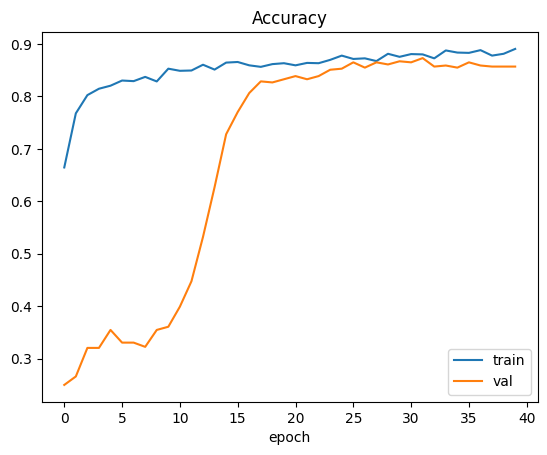

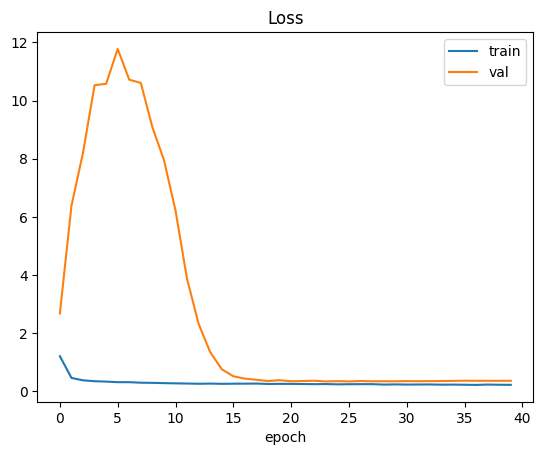

In [11]:
def plot_curves(history):
    h = history.history
    plt.figure(); plt.plot(h["accuracy"]); plt.plot(h["val_accuracy"]); plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(["train","val"]); plt.show()
    plt.figure(); plt.plot(h["loss"]); plt.plot(h["val_loss"]); plt.title("Loss"); plt.xlabel("epoch"); plt.legend(["train","val"]); plt.show()

plot_curves(history)

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
cm = confusion_matrix(y_test, y_pred)

Test accuracy: 0.8531
              precision    recall  f1-score   support

 Closed_Eyes       0.97      0.95      0.96        61
   Open_Eyes       0.95      0.97      0.96        61
        Yawn       0.77      0.71      0.74        62
     No_Yawn       0.73      0.79      0.76        61

    accuracy                           0.85       245
   macro avg       0.85      0.85      0.85       245
weighted avg       0.85      0.85      0.85       245



In [13]:
with open(f"{RESULTS_DIR}/baseline_cnn_report_{run_id}.txt","w") as f:
    f.write(f"Test accuracy: {test_acc:.4f}\n\n")
    f.write(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

In [14]:
final_model_path = f"{MODEL_DIR}/baseline_cnn_final_{run_id}.keras"
model.save(final_model_path)

with open(f"{MODEL_DIR}/labels.json","w") as fp:
    json.dump({i:c for i,c in enumerate(CLASS_NAMES)}, fp)
print("saved:", final_model_path)

saved: models/baseline_cnn_final_20251009-191546.keras


In [ ]:
import cv2

def predict_image(path, model, target_size=(64,64)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    x = (img/255.0).astype("float32")
    x = np.expand_dims(x, axis=0)  # (1,H,W,C)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return CLASS_NAMES[idx], float(probs[idx]), probs

# example:
# pred, conf, _ = predict_image("data/sample/example.jpg", model)
# print(pred, conf)